# Cryosphere model Comparison tool (CmCt) GRACE Mascon Gravimetry Tool

## Mascon dataset description

The CmCt GRACE mascon tool compares user uploaded ice sheet model to GRACE mascon data derived from the GRACE satellite.

The CmCt processes the model to create the same mascon space as the NASA GSFC GRACE mascon product, therefore bringing the ice sheet model and GRACE data to the same spatial resolution for comparison. After the interpolation to the same mascon space has been achieved, the ice sheet model is averaged over within the mascon space to provide a direct qualitative comparison.

For comparison to the user's model, the tool currently uses the `GSFC.glb.200301_201607_v02.4-GeruoA` GRACE mascon product from 2003 to 2016 that can be requested at the NASA GSFC dataset [main distribution site](https://disc.gsfc.nasa.gov/). This dataset is available upon request. Future developments will include adding the data from the GRACE-FO (GRACE Follow-On) mission to support the full time range from 2003 to 2021. 

## Input data requirements

The input ice sheet model should be saved as a netCDF file. There are several requirements for the comparison:

### `Lithk` variable

The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison.

### Rectangular grid

At time of writing, models *must* be defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. (Note, NOT a lat-lon grid!) The ISMIP6 standard projection is defined [here](http://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6_wiki_page). 

### Date range

The date range for the GRACE data spans 2013 to 2016. The start and end dates for the tool comparison are fixed:

`start_date = '2004-01-01' # 'YYYY-MM-DD'`

`end_date = '2014-01-01' # 'YYYY-MM-DD'`

The user may upload a single input file that includes multiple years. A future enhancement will enable users to select the desired start and end date range for the comparison. 

## Using this tool

This tool runs in Jupyter Appmode. The user interface buttons enable upload, plotting, and download.

1. Download the example output, if desired, using the Download Example button.
1. Upload model data for comparison using the Upload File button.
1. Note the Time Range for Comparison is fixed (2004-01-01 to 2014-01-01).
1. Plot GRACE Mascon and Ice Sheet Model Comparison using the Plot Data button.
1. Download the results using the Download Plot button.

The tool first processes the NASA GSFC GRACE product and specifies the mascon space. Then averages over the observational data within the specified mascon space. The CmCt takes the uploaded ice sheet model and converts it to the same mascon space as the observational data. Once the data is in the mascon space it averages over the data within the same space, then plots the comparison side by side.

### Future enhancements

+ A drop-down box will be provided for users to select the start and end date range for the comparison. 
 
+ Data from the GRACE-FO (GRACE Follow-On) mission will be added, to support the full time range from 2003 to 2021. 

## Tool Output

The CmCt creates the GRACE mascon plot and the model mascon plot so the user can  qualitatively compare the model output with the observational data. The plots can be easily downloaded with the Download Plot tab. 

In [1]:
# Import Modules

In [2]:
# set geospatial python3 kernel to provide needed packages
import os,sys
import glob as glob
import numpy as np
import h5py
import mascons
import xarray as xr
import glob as glob

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))

import ipywidgets as widgets
from IPython.display import display,clear_output,HTML
import PIL.Image # Python Image Library

# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

warnings.filterwarnings('ignore')

## Set Polar Sterographic Projection definition:

##### Projection can be defined from the loaded model or by setting the definition independent of the model. 
#Since the CmCt uses a standard projection, it is probably best to use the second method.

In [3]:
# Method : Set model projection from standard definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

# Set Time Range for Comparison

In [4]:
# start and end dates for model/observation comparison
start_date = '2004-01-01' # 'YYYY-MM-DD'
end_date = '2014-01-01' # 'YYYY-MM-DD'

In [5]:
# filename for output plot
plot_filename = 'Mascon_comp.png'

### Select Parameters

In [6]:
from CMCT_gaivimetry_select_data_parameters import *


parameters = CMCT_gaivimetry_select_data_parameters()
print(parameters)

{'loginname_widget': 'rbasnet'}


In [7]:
from datetime import datetime

output_dir = os.path.expanduser('/home/jovyan/CmCt/RUNS/')

# Construct run_id using username and current time
date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
date2 = datetime.now().strftime('%Y%m%dT%H%M%S')

run_id = parameters['loginname_widget']+ "_" + date2
# print(run_id)

# Create upload dir path
output_dir_act = output_dir + run_id + "/"
print(output_dir_act)

#Make upload directory
os.mkdir(output_dir_act)

output_nc_filename=output_dir_act+'CMCT_'+run_id+'.01.meansdgrids.nc'
print(output_nc_filename)


/home/jovyan/CmCt/RUNS/rbasnet_20240520T185803/
/home/jovyan/CmCt/RUNS/rbasnet_20240520T185803/CMCT_rbasnet_20240520T185803.01.meansdgrids.nc


## Load GRACE and Model Data:

In [8]:
#Data dir and model name
Datadir =os.path.expanduser('/home/jovyan/CmCt/notebooks/Gravimetry/')
model_file = "lithk_GIS_JPL_ISSM_asmb.nc"

In [9]:
def loadGsfcMascons():
    #Load Mascons data
    inpath_1 =os.path.expanduser('/home/jovyan/CmCt/notebooks/Gravimetry/')

    # Load GSFC mascons
    h5_filename = inpath_1 + 'gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd.h5'

    try:
        gsfc = mascons.load_gsfc_solution(h5_filename, lon_wrap='pm180')
    except:
        print('Error: Failed to load GSFC mascons.')
    return gsfc

In [10]:
# Load user's uploaded model data
def loadGisModel(nc_filename):
    
    # Load GIS model into an Xarray
    try:
        gis_ds = xr.open_dataset(nc_filename, autoclose=True, engine='netcdf4')
    except:
        print('Error: Failed to open model data; unexpected format found. Terminating calculation.')

        
    # check for the lithk variable
    try:
        lithk = gis_ds['lithk']
    except:
        print('Error: lithk variable expected but not found in model. Terminating calculation.')

        
    return gis_ds

# GRACE Mascon Mean Computation

In [11]:
# Compute mascon means
def computeMasconMeans(gsfc):
    
    global lat_centers
    global lon_centers
    global max_lons
    global min_lons
    global min_lats
    global max_lats
    global min_mscns
    global max_mscns
    global diverging_max
    global diverging_min
    global I_

    try:
        cmwe_delta = mascons.calc_mascon_delta_cmwe(gsfc, start_date, end_date)
    except:
        with output_widget:
            print('Error: Failed to calculate mascon delta. Terminating calculation.')
        return None
        
    # Select only GIS mascons
    I_ = gsfc.locations == 1
    cmwe_delta = cmwe_delta[I_]
    lat_centers = gsfc.lat_centers[I_]
    lon_centers = gsfc.lon_centers[I_]
    min_lons = gsfc.min_lons[I_]
    max_lons = gsfc.max_lons[I_]
    min_lats = gsfc.min_lats[I_]
    max_lats = gsfc.max_lats[I_]

    min_mscns = np.min(cmwe_delta)
    max_mscns = np.max(cmwe_delta)

    diverging_max = np.max([np.abs(min_mscns), np.abs(max_mscns)])
    diverging_min = -diverging_max

    return cmwe_delta

## Ice Sheet Model Mascon Mean Computation 

In [12]:
def transformToGeodetic(gsfc, gis_ds):
    
    # Put model into mascon space:

    # To compare with GRACE mascons, we need to compute lat/lon coordinates 
    # for the grid locations and average them into the GSFC mascon boundaries.

    # First, we must transform from the original polar stereographic projection 
    # into a geodetic lat/lon coordinate system. We plot the result of 
    # this transformation to verify that the transformation was successful.

    # Then, we spatially average the data into mascon space and once more plot our result.

    # TODO: evaluate whether this transform has failed and return appropriate error
    
    # fetch the lithk variable from the model data structure
    lithk = gis_ds['lithk']
        
    # Transform projection to lat/lon
    geodetic = ccrs.Geodetic(globe=ccrs.Globe('WGS84'))

    yv, xv = np.meshgrid(gis_ds.y.data, gis_ds.x.data)

    ll = geodetic.transform_points(src_crs=polar_stereographic, x=xv.flatten(), y=yv.flatten())
    lons = ll[:,0]
    lats = ll[:,1]

    # Calc difference between 2015.0 and 2000.0:
    lithk_delta = (lithk[3] - lithk[0]).data.transpose().flatten()

    # Plot Model Mascon average over the timeseries

    lithk_start = lithk.interp(time=start_date).data.transpose().flatten()
    lithk_end = lithk.interp(time=end_date).data.transpose().flatten()

    lithk_delta = lithk_end - lithk_start

    # Mascon-average lithk from GIS
    lithk_delta[np.isnan(lithk_delta)] = 0
    lithk_mascons = mascons.points_to_mascons(gsfc, lats, lons, lithk_delta)
  

    # Ice thickness (m) to cm water equivalent:
    rho_ice = 934 # kg/m^3
    rho_water = 1000 # kg/m^3
    lithk_mascons_cmwe = lithk_mascons * rho_ice / rho_water * 100


    # these variables depend only on the mascons here, which are fixed.
    mscns_trim = lithk_mascons_cmwe[I_]

    
    return mscns_trim, lithk_mascons_cmwe

In [14]:
def plotFigure(cmwe_delta, mscns_trim,cmwe_diff, gsfc, I_, lithk_mascons_cmwe):

    plt.figure(figsize=(24,14)) #, dpi=300)

    # Observed
    ax1 = plt.subplot(131, projection=polar_stereographic)
    ax1.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

    sc = ax1.scatter(lon_centers, lat_centers, 1, c=cmwe_delta, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_delta))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax1.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax1, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax1.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    # download coastline here: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

    # ax1.coastlines(resolution='10m', zorder=7, linewidth=0.5)
    ax1.gridlines(zorder=8, linestyle=':', linewidth=0.5)

    ax1.set_title('Observed mass change\n({0} to {1})'.format(start_date, end_date), size=14)

    sc.remove()


    # Modeled
    ax2 = plt.subplot(132, projection=polar_stereographic)
    ax2.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

    sc = ax2.scatter(gsfc.lon_centers[I_], gsfc.lat_centers[I_], 1, c=lithk_mascons_cmwe[I_], zorder=0,
                     transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(lithk_mascons_cmwe[I_]))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax2.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax2, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax2.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # ax2.coastlines(resolution='10m', zorder=7, linewidth=0.5)
    ax2.gridlines(zorder=8, linestyle=':', linewidth=0.5)

    # add model filename to subplot's title
    #ax2.set_title('Modeled mass change\n({0} to {1}\n{3})'.format(start_date, end_date, file_name[1]), size=14)
    model_filename = str.split(file_name, '/')[1]
    ax2.set_title('Modeled mass change: {0}\n({1} to {2})'.format(model_filename, start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=0.83)


    # Obeserved-Modeled
    ax3 = plt.subplot(133, projection=polar_stereographic)
    ax3.set_extent([-65, -20, 57, 84]) # Map bounds, [west, east, south, north]

    sc = ax3.scatter(lon_centers, lat_centers, 1, c=cmwe_diff, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)    
    
    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_diff))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax3.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax3, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax3.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # ax3.coastlines(resolution='10m', zorder=7, linewidth=0.5)
    ax3.gridlines(zorder=8, linestyle=':', linewidth=0.5)

    # add model filename to subplot's title
    #ax3.set_title('Modeled mass change\n({0} to {1}\n{3})'.format(start_date, end_date, file_name[1]), size=14)
    model_filename = str.split(file_name, '/')[1]
    ax3.set_title('Obeserved-Modeled mass change: {0}\n({1} to {2})'.format(model_filename, start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=0.83)
    
    #plot_filename = 'Mascon_comp.png'
    plt.savefig(plot_filename)
    
    plt.show()

In [15]:
def write_to_netcdf(cmwe_diff,output_filename):
    # Create a DataArray
    # data_array = xr.DataArray(cmwe_diff, dims=['x'], coords={'x': np.arange(len(cmwe_diff))})
    data_array = xr.DataArray(cmwe_diff, dims=['mascons'], coords={'mascons': np.arange(len(cmwe_diff))})

    # Create a Dataset and add the DataArray under the variable name 'cmwe_diff'
    ds = xr.Dataset({'cmwe_diff': data_array})

    # Write the dataset to a NetCDF file, including it in the 'residue' group
    ds.to_netcdf(output_filename, group='residue', mode='w')

    print(f'Data written to {output_filename}.')

In [16]:
# Plot GRACE Mascon and Ice Sheet Model Comparison

In [17]:
# do the computation:
# def runProcessing(file = None):
def runProcessing(file = None,output_filename=output_nc_filename):    
    output_filename

    update_progress(0)
    
    # load mascons 
    gsfc = loadGsfcMascons()
    if gsfc is not None:
        update_progress(0.10)
    else: 
        return None
    
    # load user's input model
    gis_ds = loadGisModel(file)
    if gis_ds is not None:
        update_progress(0.20)
    else: 
        return None
    
    # compute the mascon means
    cmwe_delta = computeMasconMeans(gsfc)
    if cmwe_delta is not None:
        update_progress(0.30)
    else:
        return None
    
    # Put model into mascon space
    try:
        mscns_trim, lithk_mascons_cmwe = transformToGeodetic(gsfc, gis_ds)
    except:
        print('Error: model transform to geodetic failed. Terminating calculation.')

        
    update_progress(0.60) 



    # calculate and write results as netcdf file
    try:
        ###########################################################################
        ### new variable cmwe_diff to write to nedcdf file as output
        cmwe_diff=mscns_trim-cmwe_delta
    except:
        print('Error: Calculation failed.') 
    update_progress(0.80)

    # Save results to NetCDF
    try:
        write_to_netcdf(cmwe_diff,output_filename)
    except Exception as e:
        print(f'Error: Failed to write NetCDF file. {e}')

    
    # Plot results
    try:
        # plotFigure(cmwe_delta, mscns_trim, gsfc, I_, lithk_mascons_cmwe)
        plotFigure(cmwe_delta, mscns_trim,cmwe_diff, gsfc, I_, lithk_mascons_cmwe)
    except:
        print('Error: plotting failed.')
           
        
    # todo: put in some checks
    return 'Success'

In [18]:
# update processing progress bar
def update_progress(progress):
    title = 'Plotting Data'
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)    

Plotting Data [--------------------] 0.0%
Plotting Data [##------------------] 10.0%
Plotting Data [####----------------] 20.0%
Plotting Data [######--------------] 30.0%
Plotting Data [############--------] 60.0%
Plotting Data [################----] 80.0%
Data written to /home/jovyan/CmCt/RUNS/rbasnet_20240520T185803/CMCT_rbasnet_20240520T185803.01.meansdgrids.nc.


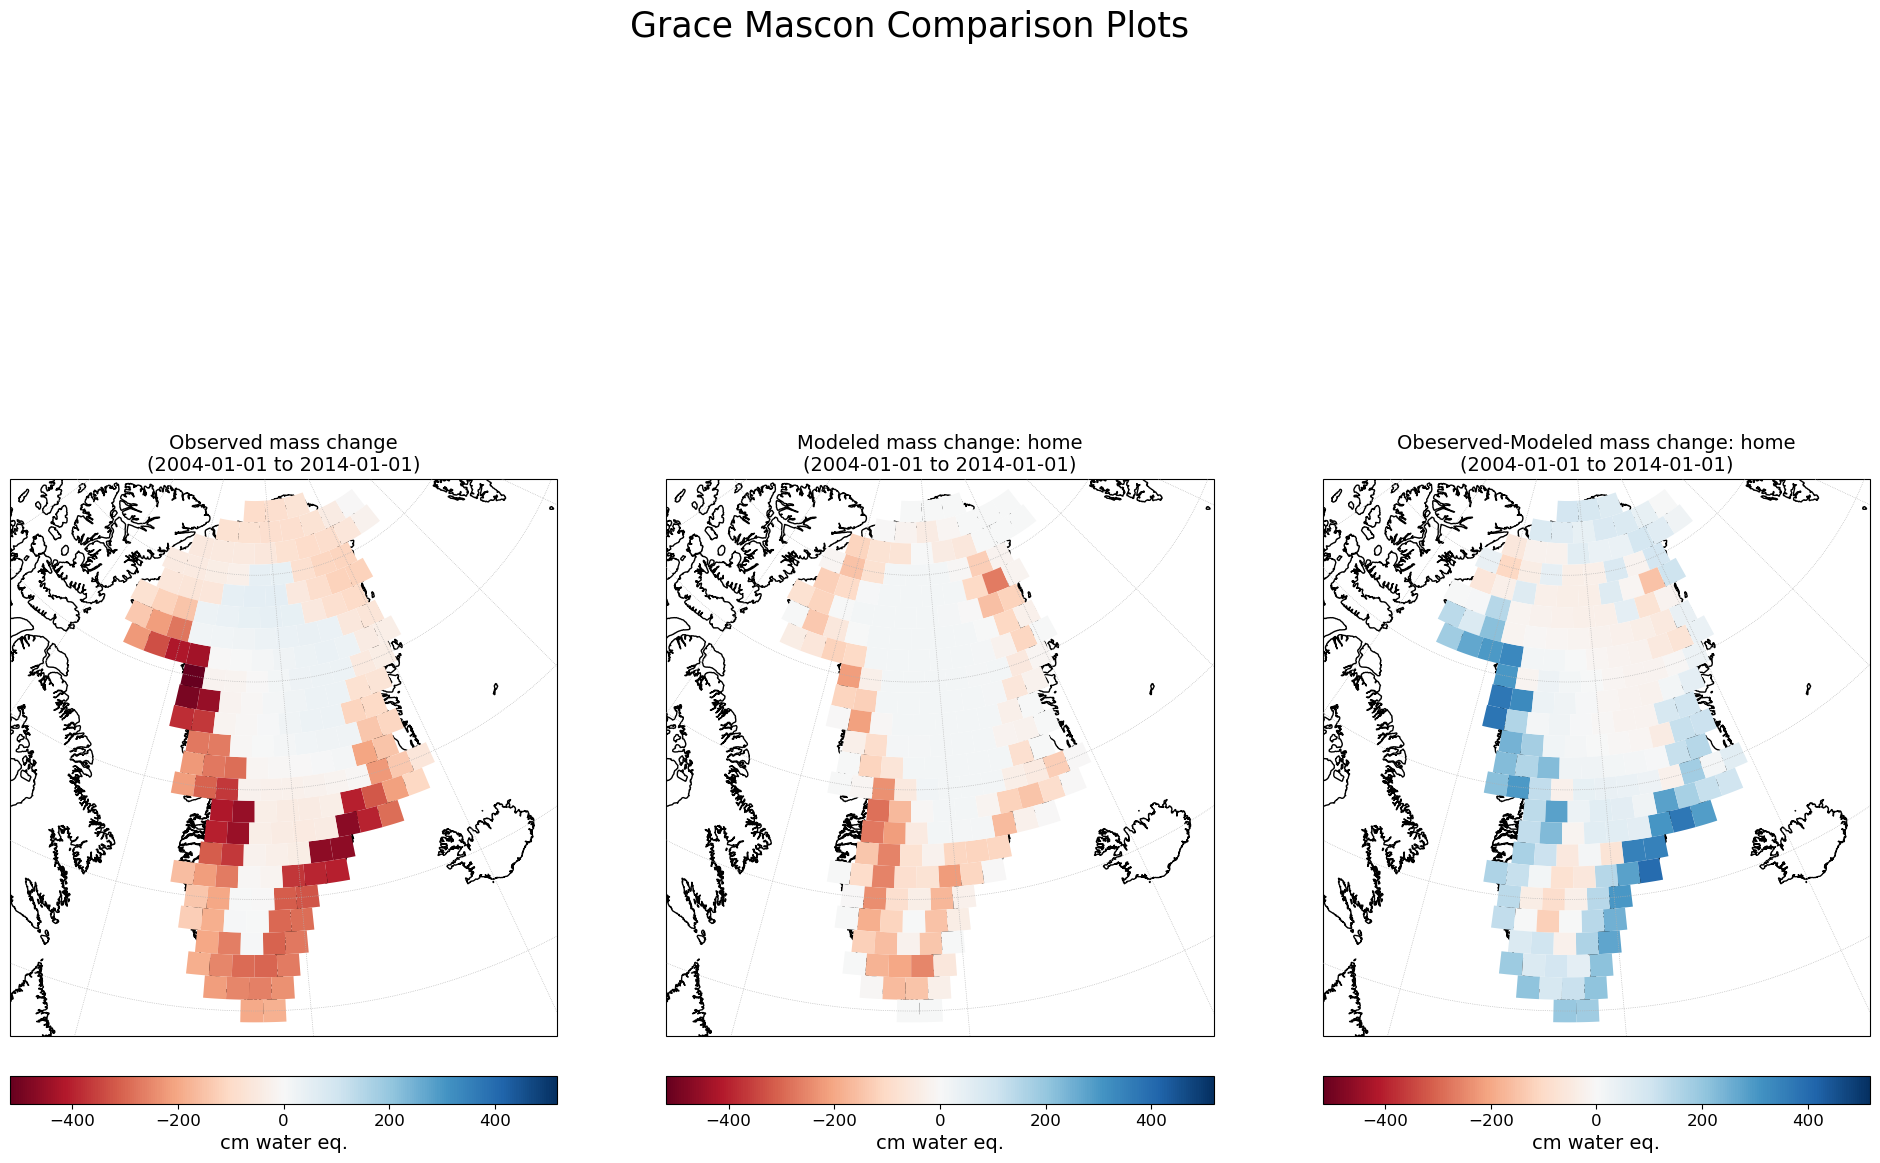

'Success'

In [19]:
# Process
file_name=Datadir+model_file
# runProcessing(file_name)
runProcessing(file_name, output_filename=output_nc_filename)